<a href="https://colab.research.google.com/github/RagaaM/Scriba/blob/main/EfficientNet_Royals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# m --> my comment
# change CPU to GPU
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchsummary
!pip install efficientnet_pytorch
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import metrics
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from tqdm.autonotebook import tqdm

In [3]:
#parameters
batch_size = 50
im_size = 150

In [4]:
train_set = '/content/drive/MyDrive/SCRIBA/Dataset-Royals/dataset royals updated/train'
test_set = '/content/drive/MyDrive/SCRIBA/Dataset-Royals/dataset royals updated/test'
print(test_set)

/content/drive/MyDrive/SCRIBA/Dataset-Royals/dataset royals updated/test


In [5]:
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()
im_size = 150

train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = train_set , transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)

mean,std = normalization_parameter(train_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=299),  # Image net standards
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

#inverse normalization for image plot
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

In [7]:
#splitting files stage
def data_loader(train_data,test_data = None , valid_size = None , batch_size = 32):
    train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
    if(test_data == None and valid_size == None):
        dataloaders = {'train':train_loader}
        return dataloaders
    if(test_data == None and valid_size!=None):
        data_len = len(train_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        valid_loader = DataLoader(train_data, batch_size= batch_size, sampler=valid_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader}
        return dataloaders
    if(test_data != None and valid_size!=None):
        data_len = len(test_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
        test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
        return dataloaders

In [8]:
#data loader
train_data = torchvision.datasets.ImageFolder(root = train_set, transform = train_transforms)  #uncommented
test_data = torchvision.datasets.ImageFolder(root = test_set, transform = test_transforms)
dataloaders = data_loader(train_data,test_data , valid_size = 0.2 , batch_size = batch_size)
#label of classes
classes = train_data.classes
# print(classes)
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]
# print(dataloaders.keys())

In [9]:
import matplotlib.pyplot as plt
import random
# #plotting rondom images from dataset
# def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
#     n_row = int(n_figures/2)
#     fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
#     for ax in axes.flatten():
#         a = random.randint(0,len(data))
#         (image,label) = data[a]
#         print(type(image))
#         label = int(label)
#         l = encoder[label]
#         if(inv_normalize!=None):
#             image = inv_normalize(image)
        
#         image = image.numpy().transpose(1,2,0)
#         im = ax.imshow(image)
#         ax.set_title(l)
#         ax.axis('off')
#     plt.show()
# class_plot(train_data,encoder,inv_normalize)

In [10]:
#using efficientnet model based transfer learning
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet =  EfficientNet.from_pretrained('efficientnet-b0')
        self.l1 = nn.Linear(1000 , 256)
        self.dropout = nn.Dropout(0.75)
        self.l2 = nn.Linear(256,4)    #modify 6 --> 10  (in pytorch it has to be numofclasses+1 (stackoverflow answer)) (num of classes)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

torch.cuda.empty_cache()   # just when use GPU to pervent any GPUs errors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
classifier = Classifier().to(device)

cpu
Loaded pretrained weights for efficientnet-b0


In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
import numpy as np
import torch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [13]:
def train(model,dataloaders,criterion,num_epochs=10,lr=0.00001,batch_size=8,patience = None):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc = list()
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)   # if loss improved
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr*0.8
        if(epoch%10==0):
            lr = 0.0001

        for phase in phase1:
            if phase == ' train':
                model.train()
            else:    # test and val
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.FloatTensor)   # use cpu instead of gpu
                target = target.type(torch.LongTensor)
                optimizer.zero_grad()  #This will in general have lower memory footprint, and can modestly improve performance instead of giving zero value.
                output = model(data)
                loss = criterion(output, target)  # hn-check hena
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 300 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'val'):
                earlystop(epoch_loss,model)

            if(phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            print(earlystop.early_stop)
        if(earlystop.early_stop):
            print("Early stopping")
            model.load_state_dict(torch.load('./checkpoint.pt'))
            break
        print('{} Accuracy: '.format(phase),epoch_acc.item())
    return losses,acc

In [14]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.FloatTensor)   # change torch.cuda.FloatTensor --> torch.FloatTensor
        target = target.type(torch.LongTensor)   # change torch.cuda.LongTensor --> torch,LongTensor   (CPU instead of GPU)
        classifier.eval()
        output = classifier(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [15]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

# To plot the wrong predictions given by model
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+c + ',' +'P:'+w
        if inv_normalize !=None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [16]:
def train_model(model,dataloaders,criterion,num_epochs,lr=0.0001,batch_size=8,patience = None,classes = None):
    dataloader_train = {}
    losses = list()
    accuracy = list()
    key = dataloaders.keys()
    for phase in key:
        if(phase == 'test'):
            perform_test = True
        else:
            dataloader_train.update([(phase,dataloaders[phase])])
    losses,accuracy = train(model,dataloader_train,criterion,num_epochs,lr,batch_size,patience)
    error_plot(losses)
    acc_plot(accuracy)
    if(perform_test == True):
        true,pred,image,true_wrong,pred_wrong = test(dataloaders['test'])
        wrong_plot(12,true_wrong,image,pred_wrong,encoder,inv_normalize)
        performance_matrix(true,pred)
        if(classes !=None):
            plot_confusion_matrix(true, pred, classes= classes,title='Confusion matrix, without normalization')

Epoch: 0
train Epoch: 0  [0/35 (0%)]	Loss: 0.835483 	Acc: 0.460000
False
val Epoch: 0  [0/25 (0%)]	Loss: 0.118096 	Acc: 0.060000
Validation loss decreased (inf --> 0.118096).  Saving model ...
False
val Accuracy:  0.06
Epoch: 1
train Epoch: 1  [0/35 (0%)]	Loss: 0.681492 	Acc: 0.540000
False
val Epoch: 1  [0/25 (0%)]	Loss: 0.122378 	Acc: 0.020000
EarlyStopping counter: 1 out of 55
False
val Accuracy:  0.02
Epoch: 2
train Epoch: 2  [0/35 (0%)]	Loss: 0.543068 	Acc: 0.640000
False
val Epoch: 2  [0/25 (0%)]	Loss: 0.115487 	Acc: 0.040000
Validation loss decreased (0.118096 --> 0.115487).  Saving model ...
False
val Accuracy:  0.04
Epoch: 3
train Epoch: 3  [0/35 (0%)]	Loss: 0.436869 	Acc: 0.680000
False
val Epoch: 3  [0/25 (0%)]	Loss: 0.111108 	Acc: 0.040000
Validation loss decreased (0.115487 --> 0.111108).  Saving model ...
False
val Accuracy:  0.04
Epoch: 4
train Epoch: 4  [0/35 (0%)]	Loss: 0.350889 	Acc: 0.680000
False
val Epoch: 4  [0/25 (0%)]	Loss: 0.109873 	Acc: 0.040000
Validation los

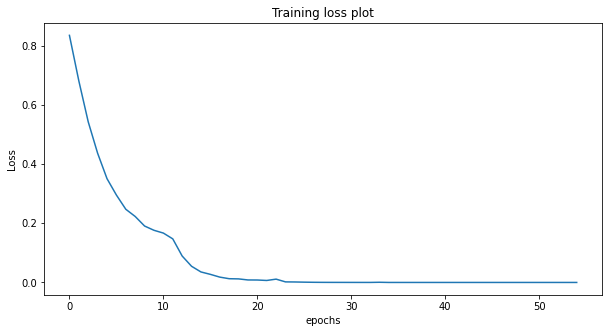

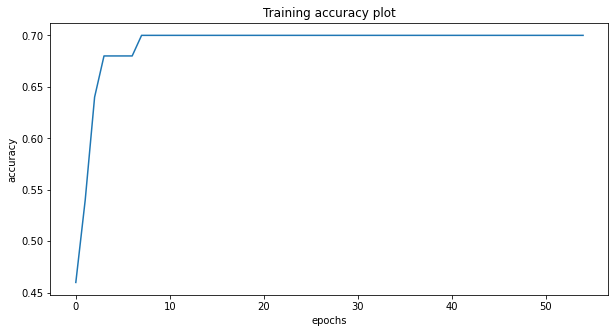

tensor(0.2600, dtype=torch.float64) 0.739380931854248
Classes in order Actual and Predicted


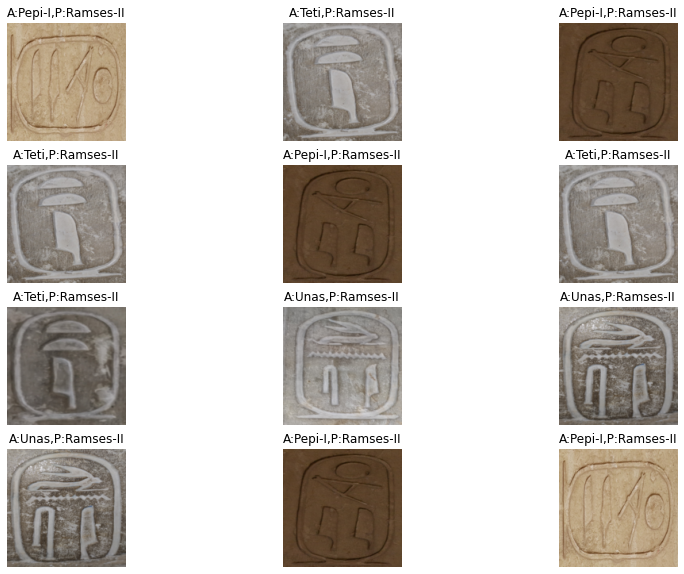

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 57.49999999999999 Recall: 54.166666666666664, Accuracy: 65.0: ,f1_score: 51.515151515151516
Confusion matrix, without normalization
[[4 2 0 0]
 [0 6 0 0]
 [1 2 3 0]
 [0 2 0 0]]


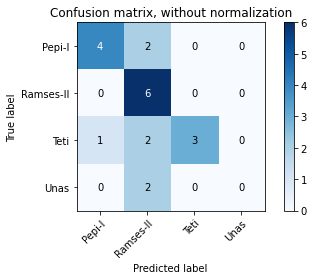

In [18]:
train_model(classifier,dataloaders,criterion,55, patience = 55 , batch_size = batch_size , classes = classes)

In [19]:
#import csv
#import pandas


#def getInput(input):
 # File = '/content/drive/MyDrive/SCRIBA/Dataset-Royals/Dataset-Royals.csv'

 # print("Input is :",input)

  #result = pandas.read_csv(File)
  # print(result)

  #FileReader = csv.reader(open(File, "r"), delimiter=",")

  #search = input

  #for row in FileReader:
      #if current rows 2nd value is equal to input, print that row
   #   if search == row[1]:
    #      print (row)

In [20]:
import csv
import pandas

# Function to read the royal's transltrated and otehr names from the most accurate result of the image + send it to the api to display in UI 
def getInput(input):
  File = '/content/drive/MyDrive/SCRIBA/Dataset-Royals/Dataset-Royals.csv'

  royal = input

  result = pandas.read_csv(File)

  FileReader = csv.reader(open(File, "r"), delimiter=",")

  RoyalName = ""
  Transltrated = ""
  OtherName = ""


  for row in FileReader:
      #if current rows 2nd value is equal to input, print that row
      # print ("Royal name:",row[0])
      # print ("Transltrated: ",row[1])
      # print ("Other: ",row[2])
      if row[0] == input:
        RoyalName = row[0]
        Transltrated = row[1]
        OtherName = row[2]
        if(row[2]==""):
          OtherName = "None"

  print(RoyalName,"---",Transltrated,"---", OtherName)

  #Write code to send outputs to api to display in app UI

In [21]:
from PIL import Image
import numpy as np
import cv2

Royals = np.array(['Pepi-I', 'Ramses-II', 'Teti', 'Unas'])
input = ""


def predict(model,image,device,encoder,transforms = None,inv_normalize = None):
    #model = torch.load('./model.h5')
    model.eval()
    if(isinstance(image,np.ndarray)):
      image = Image.fromarray(image)
    if(transforms!=None):
        image = transforms(image)
    data = image.expand(1,-1,-1,-1)
    data = data.type(torch.FloatTensor).to(device)
    sm = nn.Softmax(dim = 1)
    output = model(data)
    output = sm(output)
    _, preds = torch.max(output, 1)
    img_plot(image,inv_normalize)
    prediction_bar(output,encoder)
    return preds
def prediction_bar(output,encoder):
    output = output.cpu().detach().numpy()
    a = output.argsort()
    print(a)
    a = a[0]
    print(a)
    
    size = len(a)
    if(size>5):
        a = np.flip(a[-5:])
    else:
        a = np.flip(a[-1*size:])
    prediction = list()
    clas = list()
    for i in a:
      prediction.append(float(output[:,i]*100))
      clas.append(str(i))
    for i in a:
        print('Class: {} , confidence: {}'.format(encoder[int(i)],float(output[:,i]*100)))
    index = a[0].item()
    input = getInput(Royals[index])
    #print(input)
    getInput(input)
    print("The Royal is",Royals[index])
    plt.bar(clas,prediction)
    plt.title("Confidence score bar graph")
    plt.xlabel("Confidence score")
    plt.ylabel("Class number")
 
def img_plot(image,inv_normalize = None):
    if(inv_normalize!=None):
        image = inv_normalize(image)
    image = image.cpu().numpy().transpose(1,2,0)
    plt.imshow(image)
    plt.show()

In [ ]:
# image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Royals/train/Pepi-I/Pepi_I_6.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image, (224, 224))   
# gaussian_blur = cv2.GaussianBlur(image, (5,5), 1.5)
# ret, thresh = cv2.threshold(gaussian_blur, 0, 255, cv2.THRESH_BINARY_INV + 
#                                         cv2.THRESH_OTSU)  

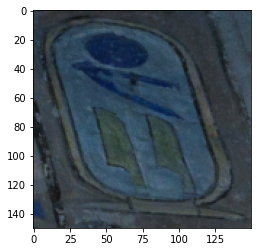

[[3 2 1 0]]
[3 2 1 0]
Class: Pepi-I , confidence: 94.55736541748047
Class: Ramses-II , confidence: 5.418889999389648
Class: Teti , confidence: 0.01763705536723137
Class: Unas , confidence: 0.006110218819230795
Pepi-I --- Pepi --- None
 ---  --- 
The Royal is Pepi-I


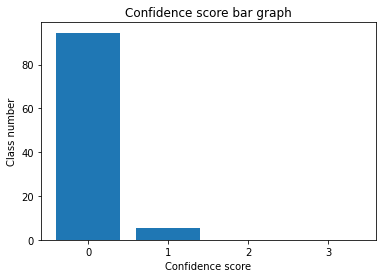

In [25]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Royals/dataset royals updated/test/Pepi-I/Pepi_I_3.jpg')  
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

In [23]:
import csv
import pandas

File = '/content/drive/MyDrive/SCRIBA/Dataset-Royals/Dataset-Royals.csv'

input = 'Ramses-II'

print("test:",input)

result = pandas.read_csv(File)
print(result)

FileReader = csv.reader(open(File, "r"), delimiter=",")


RoyalName = ""
Transltrated = ""
OtherName = ""


for row in FileReader:
    #if current rows 2nd value is equal to input, print that row
    # print ("Royal name:",row[0])
    # print ("Transltrated: ",row[1])
    # print ("Other: ",row[2])
    if row[0] == input:
      RoyalName = row[0]
      Transltrated = row[1]
      OtherName = row[2]
      if(row[2]==""):
        OtherName = "None"


print(RoyalName, Transltrated, OtherName)



# def loadCSV(self):
#   search = input  
#   print(search)

#   with open(csv) as csvfile:
#     csvloader = csv.reader(csvfile, delimiter="=", quotechar="|")

#     for row in csvloader:
#       print(row)
#       if search == row[0]:
#         print(row)
#         self.name = search
#         self.tran = row[1]
#         self.other = row[2]

test: Ramses-II
  Royal Name (English) Transliterated Name   Other Names
0               Pepi-I                 Pepi          NaN
1            Ramses-II         User Maat Ra  setep en Ra
2                 Teti                 Teti          NaN
3                 Unas                 Unas          NaN
Ramses-II User Maat Ra setep en Ra
